## Program to implement Random Forest:

Imports needed: 

In [2]:
from random import seed
from random import randrange
from csv import reader
import pandas as pd
import numpy as np
from math import sqrt
import multiprocessing as mp
import timeit
import matplotlib.pyplot as plt

Function to load the csv file: 

In [3]:
def load_csv(filename1):
    file1 = open(filename1, "rt")
    lines1 = reader(file1)
    dataset1 = list(lines1)
    return dataset1

Function to convert the String values to floats:

In [4]:
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

Function to convert String values to integer:

In [5]:
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

Function to divide the dataset into k folds(k=n_folds here):

In [6]:
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

Function to calculate accuracy percentage:

In [7]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Function to evaluate an algorithm using cross validation split:

In [8]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

Function to split a dataset based on an attribute and an attribute value

In [9]:
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

Function to calculate the Gini index for a split dataset

In [10]:
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

Function to select the best split point for a dataset

In [11]:
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1) #Generating sample of features without replacements
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset: #Checking best possible split for among all features
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

Function to create a terminal node value

In [12]:
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

Function to create child splits for a node or make terminal

In [13]:
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

Function to build a decision tree

In [14]:
def build_tree(train, max_depth, min_size, n_features):  #Here train is actually the random subsample
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1) #we are assigning the depth as 1 for the first time
	return root


Function to make a prediction with a decision tree

In [15]:
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

Function to create a random sub-sample:

In [16]:
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
#     while len(sample) < n_sample:
#         index = randrange(len(dataset)) #Generating sample of rows without replacement
#         sample.append(dataset[index])
        
    index=np.random.choice(len(dataset),n_sample,replace=True) #Generating sample of rows with replacement
    for l1 in index:
        sample.append(dataset[l1])
        
    return sample

Function to make predictions from a list of bagged trees:

In [17]:
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count) #So we will return the prediction which has highest vote combinedly

Function for the random forest algorithm:

In [18]:
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features, typep):
	if(typep=="serial"):
		trees=serial_get_trees(n_trees, train, sample_size, max_depth, min_size, n_features)

	elif(typep=="parallel"):
		trees=parallel_get_trees(n_trees, train, sample_size, max_depth, min_size, n_features)

	else:
		print("Wrong type of parameter sent to typep")

	predictions = [bagging_predict(trees, row) for row in test]

	return(predictions)

Function to be called to get the trees(serial version):

In [19]:
def serial_get_trees(n_trees, train, sample_size, max_depth, min_size, n_features):
    trees = list()
    for i in range(n_trees): #so i defines number of trees that will be made
        tree=get_tree(train, sample_size, max_depth, min_size, n_features, 1) #We are sending dummy value 1 to l1
        trees.append(tree)
    return trees

Function to be called to get the trees(parallel version):

In [20]:
def parallel_get_trees(n_trees, train, sample_size, max_depth, min_size, n_features):
    trees = list()
    # Write the pool code here
    listd=[]
    for l1 in range(n_trees):
        listd.append(l1)
    
    pool = mp.Pool(processes=n_trees)
    trees = [pool.apply_async(get_tree, args=(train, sample_size, max_depth, min_size, n_features, l1)) for l1 in listd]
    trees = [p.get() for p in trees]
    return trees

Function to be called to get the tree for each iteration:

In [21]:
def get_tree(train, sample_size, max_depth, min_size, n_features, l1):
    sample = subsample(train, sample_size)
    tree = build_tree(sample, max_depth, min_size, n_features)
    return tree

Test RANDOM FOREST on Bank Note dataset

[1, -2.2532579659345755]
[5, 67.8351474577541]
[10, 70.929411719383]


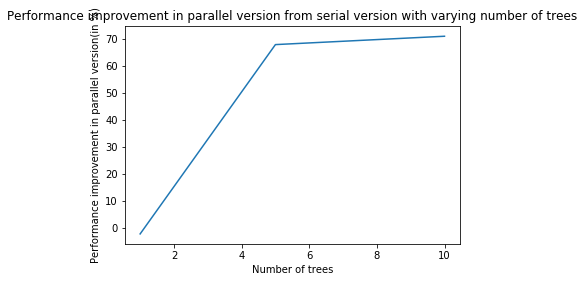

In [22]:
if __name__ == '__main__':
	seed(2)
	# load and prepare data
	filename = 'banknote_authentication_csv_2.txt'
	dataset = load_csv(filename)
	# convert string attributes and class column to integers
	for i in range(0,len(dataset[0])-1):
		str_column_to_float(dataset, i)
		# convert class column to integers
	str_column_to_int(dataset, len(dataset[0])-1)
	# evaluate algorithm
	n_folds = 5
	max_depth = 10 #Maximum number of nodes allowed from the root in the decision tree towards the leaf
	min_size = 1 #Minimum number of rows allowed under a same node
	sample_size=1.0 #This is the ratio of samples size to the actual dataset's size(number of rows)
	n_features=int(sqrt(len(dataset[0])-1))
	simulate=[]
	serial="serial"
	parallel="parallel"
	for n_trees in(1, 5, 10): #how many different trees are we making is defined by n_trees
		compare=[]
		benchmarks=[]
		#Send typep as serial or parallel
		benchmarks.append(timeit.Timer('evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size,sample_size,n_trees,n_features, serial)',
			'from __main__ import evaluate_algorithm, dataset, random_forest, n_folds, max_depth, min_size,sample_size,n_trees,n_features, serial').timeit(number=1))
		
		benchmarks.append(timeit.Timer('evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size,sample_size,n_trees,n_features, parallel)',
			'from __main__ import evaluate_algorithm, dataset, random_forest, n_folds, max_depth, min_size,sample_size,n_trees,n_features, parallel').timeit(number=1))

		compare.append(n_trees)
		compare.append(((benchmarks[0]-benchmarks[1])/benchmarks[0])*100)
		print(compare)
		simulate.append(compare)
		
	x=[]
	y=[]
	for i in range(len(simulate)):
		x.append(simulate[i][0])
		y.append(simulate[i][1])

	plt.plot(x, y)
	plt.xlabel('Number of trees')
	plt.ylabel('Performance improvement in parallel version(in %)')
	plt.title('Performance improvement in parallel version from serial version with varying number of trees')
	plt.show()

References:
[1]  https://machinelearningmastery.com/implement-random-forest-scratch-python/ . [Accessed: Jan. 20, 2019].